In [1]:
'''
/*
** Naive_Expnet.ipynb
** This file has been used to train a conv-net in phase1 to immitate facenet properties.
** In phase2, trained another fully-connected network with conv-net from phase1 to learn human emotions properties.
** Also used to find out all matrices for predicted output.
** @author: Jyotirmay Senapati, Shayan Ahmad Siddiqui
** @Date: 24th January, 2018
** @Copyright: Facial Expression Prediction, DL4CV project, Winter Sem, 2018
*/
'''

## We are working on alligned augmented training set and original+alligned test and validation set present in data/set
## folder.

# Importing modules

%load_ext autoreload
%autoreload 2
import torch
import os, time 
import cv2
from torch.autograd import Variable
import utils.data_loader_expnet as de
import utils.solver_expnet as se
import utils.model_phase1_expnet as me
import utils.model_phase2_expnet as mpe
import utils.loadOpenFace as ff
import utils.img_allign_expnet as iae
import numpy as np
from random import shuffle
import os.path
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import itertools

emo_dict = {"neutral":0, "anger":1, "contempt":2, "disgust":3, "fear":4, "happy":5, "sadness":6, "surprise":7 }
useCuda = True

## Data loading functions

In [2]:
def ReadImage(pathname, label=None, isFacenetData = False, imgAlligned = True): 
        if imgAlligned:
            img = cv2.imread(pathname)
        else:
            img = iae.img_align(pathname, label)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (96, 96), interpolation=cv2.INTER_LINEAR)
        img = np.transpose(img, (2, 0, 1)) 
        img = img.astype(np.float32) / 255.0
        I_ = torch.from_numpy(img).unsqueeze(0)
        if isFacenetData:
            if useCuda:
                I_ = I_.cuda()
        return I_

def get_path_and_labels(root, img_paths, labels, num_of_image_per_class=None):
    paths = [[f"{root}/{i}", i] for i in emo_dict.keys()]
    for path in paths:
        counter = 0
        for augmneted_file in os.listdir(path[0]):
            img_path = os.path.join(path[0], augmneted_file)
            try:
                if os.path.isfile(img_path):
                    counter+=1
                    img_paths.append(img_path)
                    labels.append(emo_dict[path[1]])
                    if num_of_image_per_class is not None and counter>num_of_image_per_class:
                        break
            except Exception as e:
                print(e)
    return img_paths, labels

def load_data(img_paths):
    imgs = []
    for img_path in img_paths:
        imgs.append(ReadImage(img_path, None,  True, True))
    return imgs

## Running data loading and splitting

In [3]:
img_paths_train, labels_train = get_path_and_labels("data/set/training", [], [])
img_paths_val, labels_val = get_path_and_labels("data/set/validation", [], [])
img_paths_test, labels_test = get_path_and_labels("data/set/testing", [], [])
imgs_train = load_data(img_paths_train)
imgs_val = load_data(img_paths_val)
imgs_test = load_data(img_paths_test)
print("Loaded data ")
print("Training : "+str(len(imgs_train)))
print("Validation : "+str(len(imgs_val)))
print("Test : "+str(len(imgs_test)))



Loaded data 
Training : 2092
Validation : 131
Test : 130


## Function to load the pretrained facenet model

In [4]:
def prepareOpenFace(useCuda=True, gpuDevice=0, useMultiGPU=False):
    print("Preparing openface object")
    model = ff.netOpenFace(useCuda, gpuDevice)
    model.load_state_dict(torch.load(os.path.join('./utils/pretrained_model/', 'openface.pth')))
    if useMultiGPU:
        model = nn.DataParallel(model)
    return model

## Running facenet and obtaining training set scores

In [5]:
# Running openface network.
nof = prepareOpenFace()
nof = nof.eval()

I = np.reshape(np.array(range(96 * 96), dtype=np.float32) * 0.01, (1,96,96))
I = np.concatenate([I, I, I], axis=0)
I_ = torch.from_numpy(I).unsqueeze(0)
I_ = I_.cuda()
    
openface_out =  Variable(torch.Tensor(len(imgs_train),736, 1, 1))

I_ = torch.cat(imgs_train, 0)
start = time.time()
for idx, x in enumerate(I_):
    x = Variable(x, volatile=True)  
    out = nof(x.view(-1, 3, 96, 96))
    openface_out[idx] = out[0]

I_val_ = torch.cat(imgs_val, 0)
I_val_ = Variable(I_val_, volatile=True)  
start = time.time()
openface_out_val_ = nof(I_val_)
torch.cuda.empty_cache()    
print("  + Forward pass took {} seconds.".format(time.time() - start))

Preparing openface object
  + Forward pass took 0.11778736114501953 seconds.


# Phase 1 : Conv layers training

## Loss function for Exp Net Conv layer training

In [6]:
def loss_expnet(output, target):
    diff = (output-target).view(-1)
    diff_normed = torch.norm(diff, 2, 0) ** 2
    ls = torch.sum(diff_normed) / output.size(0)
    return ls

## Creating batch loaders

In [7]:
train_data_p1 = de.CKData(np.array(imgs_train, dtype=np.object), openface_out.data)
val_data_p1 = de.CKData(np.array(imgs_val, dtype=np.object), openface_out_val_.data)
train_loader_p1 = torch.utils.data.DataLoader(train_data_p1, batch_size=50, shuffle=True)
val_loader_p1 = torch.utils.data.DataLoader(val_data_p1, batch_size=50, shuffle=True)

## Running Expnet Conv layers training

In [8]:
model_p1 = me.ExpNet(useCuda=True, gpuDevice=0)
solver_p1 = se.Solver(optim_args={"lr": 1e-3}, loss_func=loss_expnet)
solver_p1.train(model_p1, train_loader_p1, val_loader_p1, log_nth=1, num_epochs=3)
torch.save(model_p1.state_dict(), 'model/expnet_phase1.pt')
torch.cuda.empty_cache()

START TRAIN.
[Iteration 42/126] TRAIN loss: 3.168


/home/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Epoch 1/3] VAL   acc/loss: nan/3.219
[Iteration 84/126] TRAIN loss: 4.590
[Epoch 2/3] VAL   acc/loss: nan/3.163
[Iteration 126/126] TRAIN loss: 4.294
[Epoch 3/3] VAL   acc/loss: nan/3.238
FINISH.


## Training and Validation curves

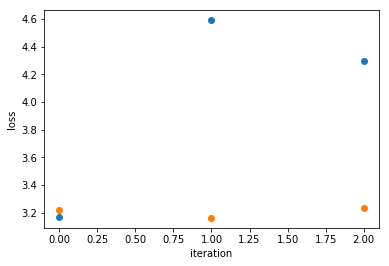

In [9]:

plt.plot(solver_p1.train_loss_history, 'o')
plt.plot(np.asarray(solver_p1.val_loss_history).squeeze(), 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.show()

# Phase 2 : Training classifier

## Cross-entropy loss function

In [8]:
def softmax_loss(x, y): 
    N = x.size(0)
    loss = 0
    max_vals = torch.max(x, 1)[0]
    for i, ipt in enumerate(x):
        diff = x[i] - max_vals[i]
        probs = torch.exp(diff)
        probs /= torch.sum(probs)
        loss += torch.log(probs[y[i].data[0]])
        
    loss = -(loss / N)
    return loss

## Creating batch loaders

In [9]:
train_data_p2 = de.CKData(np.array(imgs_train, dtype=np.object), torch.LongTensor(labels_train))
val_data_p2 = de.CKData(np.array(imgs_val, dtype=np.object), torch.LongTensor(labels_val))

train_loader_p2 = torch.utils.data.DataLoader(train_data_p2, batch_size=50, shuffle=True)
val_loader_p2 = torch.utils.data.DataLoader(val_data_p2, batch_size=50, shuffle=True)

## Tuning hyperparameter for phase2 model.

In [10]:
lrs = [0.001, 0.0005, 0.0001, 0.002]
wds = [0.01, 0.02, 0.005, 0.001]
models = []


for lr in lrs: 
    for wd in wds:
        print("learning rate:", lr, "Weight_decay:", wd)
        model_p2 = mpe.ExpNet_p2(useCuda=True, gpuDevice=0)
        solver_p2 = se.Solver(optim_args={"lr": lr, "weight_decay": wd}, loss_func=softmax_loss)
        solver_p2.train(model_p2, train_loader_p2, val_loader_p2, log_nth=1, num_epochs=1, phase2 = True)
        models.append([lr, wd, model_p2])
        torch.cuda.empty_cache()

import pickle

with open('outfile', 'wb') as fp:
    pickle.dump(models, fp)

learning rate: 0.001 Weight_decay: 0.01
START TRAIN.
[Iteration 42/42] TRAIN loss: 0.970
[Epoch 1/1] TRAIN acc/loss: 0.690/0.970
[Epoch 1/1] VAL   acc/loss: 0.743/0.900
FINISH.
learning rate: 0.001 Weight_decay: 0.02
START TRAIN.
[Iteration 42/42] TRAIN loss: 0.811
[Epoch 1/1] TRAIN acc/loss: 0.738/0.811
[Epoch 1/1] VAL   acc/loss: 0.622/1.107
FINISH.
learning rate: 0.001 Weight_decay: 0.005
START TRAIN.
[Iteration 42/42] TRAIN loss: 0.755
[Epoch 1/1] TRAIN acc/loss: 0.667/0.755
[Epoch 1/1] VAL   acc/loss: 0.674/1.135
FINISH.
learning rate: 0.001 Weight_decay: 0.001
START TRAIN.
[Iteration 42/42] TRAIN loss: 0.506
[Epoch 1/1] TRAIN acc/loss: 0.810/0.506
[Epoch 1/1] VAL   acc/loss: 0.755/0.747
FINISH.
learning rate: 0.0005 Weight_decay: 0.01
START TRAIN.
[Iteration 42/42] TRAIN loss: 0.891
[Epoch 1/1] TRAIN acc/loss: 0.643/0.891
[Epoch 1/1] VAL   acc/loss: 0.636/1.093
FINISH.
learning rate: 0.0005 Weight_decay: 0.02
START TRAIN.
[Iteration 42/42] TRAIN loss: 1.410
[Epoch 1/1] TRAIN acc/

KeyboardInterrupt: 

In [25]:
with open ('outfile', 'rb') as fp:
    models = pickle.load(fp)

for model in models:
    print(model[0], model[1])

[[0.001, 0.01, ExpNet_p2(
  (expnet_p1): ExpNet(
    (conv2d1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (conv2d2): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (conv2d3): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (conv2d4): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (pool4): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (conv2d5): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (pool5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

## Running the classifier training

In [12]:
model_p2 = mpe.ExpNet_p2(useCuda=True, gpuDevice=0)
solver_p2 = se.Solver(optim_args={"lr": 1e-3, "weight_decay": 0.01}, loss_func=softmax_loss)
solver_p2.train(model_p2, train_loader_p2, val_loader_p2, log_nth=1, num_epochs=3, phase2 = True)
torch.cuda.empty_cache()

START TRAIN.
[Iteration 42/126] TRAIN loss: 2.027
[Epoch 1/3] TRAIN acc/loss: 0.238/2.027
[Epoch 1/3] VAL   acc/loss: 0.214/1.942
[Iteration 84/126] TRAIN loss: 1.875
[Epoch 2/3] TRAIN acc/loss: 0.310/1.875
[Epoch 2/3] VAL   acc/loss: 0.253/1.912
[Iteration 126/126] TRAIN loss: 1.853
[Epoch 3/3] TRAIN acc/loss: 0.310/1.853
[Epoch 3/3] VAL   acc/loss: 0.240/1.916
FINISH.


## Training and validation loss and accuracy curves

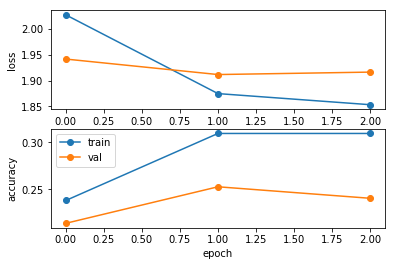

In [13]:
plt.subplot(2, 1, 1)
plt.plot(solver_p2.train_loss_history, '-o')
plt.plot(np.asarray(solver_p2.val_loss_history).squeeze(), '-o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver_p2.train_acc_history, '-o')
plt.plot(solver_p2.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Test set accuracy

In [14]:
def get_test_acc(test_data):
    out = []
    for i, x in enumerate(test_data.X):
        test_output = model_p2(Variable(x))
        max_val, idx = torch.max(test_output, 1)
        out.append(idx.data.cpu().numpy()[0])

    targets = []
    for i in test_data.y:
        targets.append(i)

    targets = np.array(targets)
    out = np.array(out)
    targets_mask = targets >= 0
    test_scores = np.mean((out == targets)[targets_mask])
    test_acc= np.mean(test_scores)
    print(test_acc)
    return test_acc, out


img_paths_test, labels_test = get_path_and_labels("data/set/testing", [], [])
imgs_test = []
for img_path_test in img_paths_test:
    imgs_test.append(ReadImage(img_path_test, None,  True, True))
    
acc, out = get_test_acc(de.CKData(np.array(imgs_test, dtype=np.object), torch.LongTensor(labels_test)))

0.19230769230769232


In [21]:
#torch.save(model_p1.state_dict(), 'model/expnet_p1.pt')
#torch.save(model_p2.state_dict(), 'model/expnet_p2.pt')

Confusion matrix, without normalization
[[25  0  0  0  0  0  0  0]
 [16  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0]
 [19  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0]
 [20  0  0  0  0  0  0  0]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


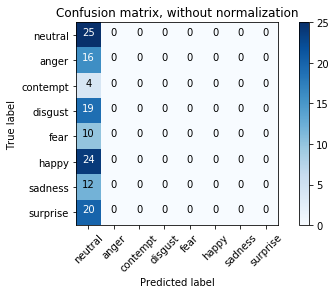

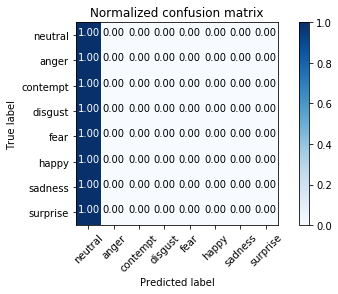

In [15]:
class_names = list(emo_dict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred, y_test = out, labels_test

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [16]:
def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

print(multiclass_roc_auc_score(y_test, y_pred))

0.5


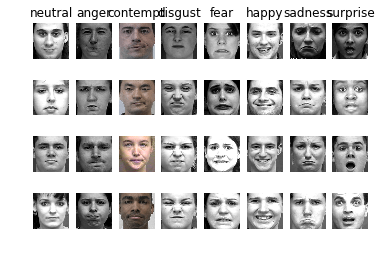

In [17]:
def ReadImage(pathname, label=None, isFacenetData = False, imgAlligned = True): 
        if imgAlligned:
            img = cv2.imread(pathname)
        else:
            img = iae.img_align(pathname, label)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img

def load_data(img_paths):
    imgs = []
    for img_path in img_paths:
        imgs.append(ReadImage(img_path, None, True, True))
    return imgs

img_paths_test, labels_test = get_path_and_labels("data/set/testing", [], [])
imgs_test = np.array(load_data(img_paths_test))

# Visualize some examples from the dataset.
# We show a few examples of images from each class.
def visualize_data(X, y, classes, samples_per_class = 4):
    num_classes = len(classes)

    for y_hat, cls in enumerate(classes):
        idxs = np.where(y == y_hat)[0]
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y_hat + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            img = X[idx]

            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

visualize_data(imgs_test, np.array(labels_test), classes = list(emo_dict), samples_per_class = 4)